In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

# Statistical Inferences into the Property Development Industry
Author: Nancy Ho

## Overview

For individuals and businesses who are new to property development, there are many difficult choices and decisions to navigate through when planning the construction and sale of their first homes. Through a statistical analysis of housing data from King County, Washington, we can learn what features go into the valuations of houses that go on the market and gain a better sense of what decisions should be made as new property developers.

## Business Problem

Property development is a broad process encompassing many other processes involved with developing infrastructure, including but not limited to purchasing plots of land, coordinating the construction of homes, and selling those homes to potential homeowners. You are put into a managerial position in charge of overseeing every step in the process of building a home and other real estate, and it can be a very rewarding business to engage in. However, these rewards are met with equally as great risks, and it can be hard to make decisions when starting out as a new developer; housing developers make the most meticulous decisions in order to maximize their profits in the end. Through a statistical analysis of housing data from King County, Washington, we can form a foundational insight into what kind of decisions to make. Some business questions we will try to answer for our purposes are:

- What kinds of factors contribute to a house's base value?
- When building a house, what factors should we look out for before beginning the construction of property?
- How does the condition of a house at the point of sale influence the value of a house?
- Are there specific features that add significant value to houses (e.g. rooms, floors)?

By the end of this analysis, you will become more prepared to make your own informed decisions as a new property developer.

## Exploring the data

For this analysis, we'll be using a .csv file, `kc_house_data.csv`, a set of data for houses in King County from the repository's `data` folder that shows the prices houses sold at and their other attributes from the time of sale. Information about each column of this dataframe can also be found in the `data` folder for further reference.

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Checking for duplicate entries and null values:

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Checking initial correlations:

In [6]:
df_corr = df.corr()
df_corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


<AxesSubplot:>

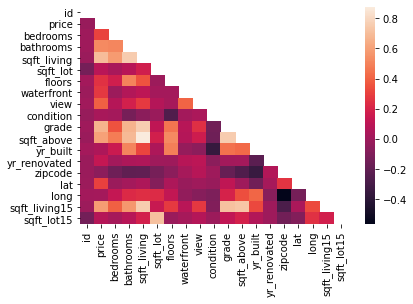

In [7]:
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_corr, mask=mask)

Since we are mainly focusing on finding the factors that influence house prices in this analysis, the target variable that we will be using is `price`. There is a lot of other data to work with, so to make sorting and working with the data a little easier, I will create a new dataframe with the columns that are the most relevant to our questions. 

To determine which columns to leave out, we can start by checking for multicollinearity in our data. This is important to check because in regression analysis, we assume that when we change one variable, all other variables are held constant. Thus, high correlation between predictors can cause problems in our analysis since any change in one predictor can cause significant changes in another and cause fluctuations in our model. By determining which predictors have high correlation with each other before performing any analysis, we can reduce the amount of misinterpretation in our final model.

In [8]:
multi_df = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
multi_df['pairs'] = list(zip(multi_df.level_0, multi_df.level_1))
multi_df.set_index(['pairs'], inplace=True)
multi_df.drop(columns=['level_1', 'level_0'], inplace=True)

multi_df.columns = ['cc']
multi_df.drop_duplicates(inplace=True)
multi_df[(multi_df.cc>.75) & (multi_df.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


From this, we can drop `sqft_above`, `grade`, `sqft_living15`, and `bathrooms` due to their high correlation with `sqft_living`, a predictor we will include in our analysis due to its own high correlation with our target variable. Looking at the correlation table for our original `df`, we can also drop other variables with low correlations to the target variable.

In [9]:
housing_df = df.drop(['lat', 'long', 'sqft_living15', 'sqft_lot15', 
                      'zipcode', 'view', 'sqft_above', 'sqft_basement', 
                      'date', 'yr_renovated', 'waterfront', 'bathrooms',
                      'grade'], axis = 1)

As a minor change, I change the `id` column to contain only strings, as each house has its own unique ID, so I would like to separate it from the numerical data in the dataframe to avoid any errors.

In [10]:
housing_df['id'] = housing_df['id'].astype('str')

Before creating our first regression model, we also check for any abnormalities in the data that we will use to filter and transform the data as necessary. To help us, we'll use histograms of all the columns in our new dataframe.

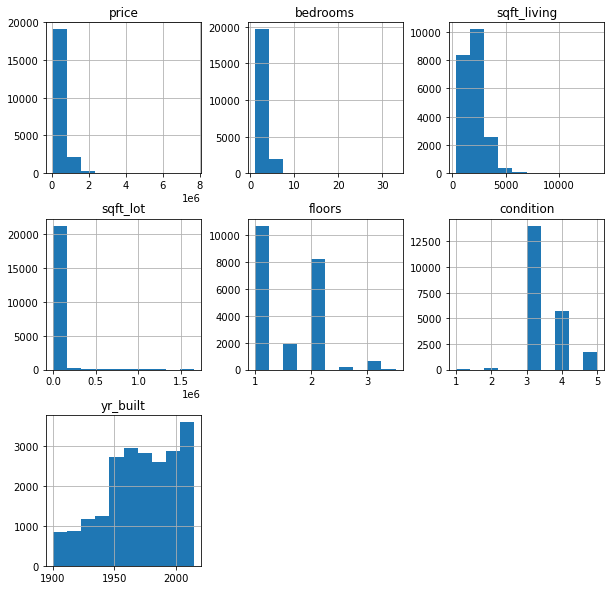

In [11]:
housing_df.hist(figsize=(10,10))
plt.show()

It looks like an outstanding feature of the data is that our continous variables seem to be skewed and contain multiple outliers, which may cause errors in our analysis later on. Our first step to cleaning the data will be to remove any outliers from `price` so that no value is any larger than 3 standard deviations from the mean:

In [12]:
z_scores = stats.zscore(housing_df.price)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
filtered_housing_df = housing_df[filtered_entries]
filtered_housing_df.head()

,id,price,bedrooms,sqft_living,sqft_lot,floors,condition,yr_built
0,7129300520,221900.0,3,1180,5650,1.0,3,1955
1,6414100192,538000.0,3,2570,7242,2.0,3,1951
2,5631500400,180000.0,2,770,10000,1.0,3,1933
3,2487200875,604000.0,4,1960,5000,1.0,5,1965
4,1954400510,510000.0,3,1680,8080,1.0,3,1987


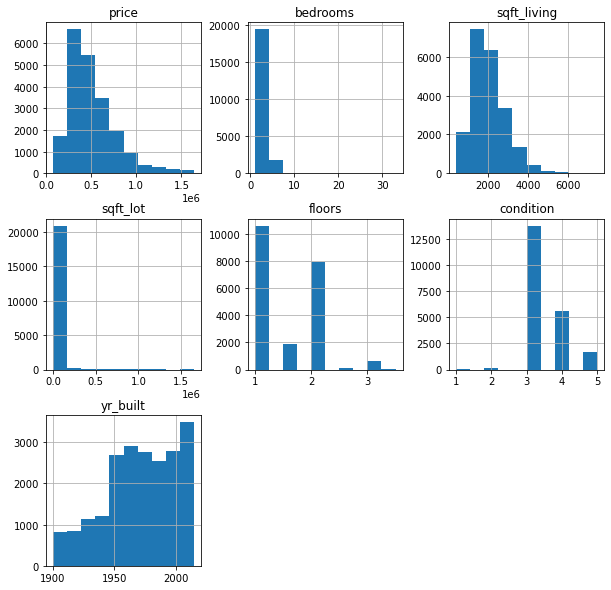

In [13]:
filtered_housing_df.hist(figsize=(10,10))
plt.show()

Next, we apply a log transformation to our continuous variables, `price`, `sqft_living`, and `sqft_lot`, to allow for a more normal distribution. To avoid a large skew in our analysis, we also apply standardization to `sqft_living` and `sqft_lot`.

In [14]:
non_normal = filtered_housing_df[['price', 'sqft_living', 'sqft_lot']]
for feat in non_normal:
    filtered_housing_df[feat] = filtered_housing_df[feat].map(lambda x: np.log(x))
    
filtered_housing_df['sqft_living'] = filtered_housing_df['sqft_living'].map(lambda x: (x - filtered_housing_df['sqft_living'].mean()) / filtered_housing_df['sqft_living'].std())
filtered_housing_df['sqft_lot'] = filtered_housing_df['sqft_lot'].map(lambda x: (x - filtered_housing_df['sqft_lot'].mean()) / filtered_housing_df['sqft_lot'].std())

<ipython-input-14-72207b622995>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_housing_df[feat] = filtered_housing_df[feat].map(lambda x: np.log(x))
<ipython-input-14-72207b622995>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_housing_df['sqft_living'] = filtered_housing_df['sqft_living'].map(lambda x: (x - filtered_housing_df['sqft_living'].mean()) / filtered_housing_df['sqft_living'].std())
<ipython-input-14-72207b622995>:6: SettingWithCopyWarning: 
A value is trying to be set on a 

In [15]:
filtered_housing_df.head()

,id,price,bedrooms,sqft_living,sqft_lot,floors,condition,yr_built
0,7129300520,12.309982,3,-1.124885,-0.375587,1.0,3,1955
1,6414100192,13.195614,3,0.772925,-0.099188,2.0,3,1951
2,5631500400,12.100712,2,-2.165666,0.260100,1.0,3,1933
3,2487200875,13.311329,4,0.112289,-0.511667,1.0,5,1965
4,1954400510,13.142166,3,-0.263548,0.022726,1.0,3,1987


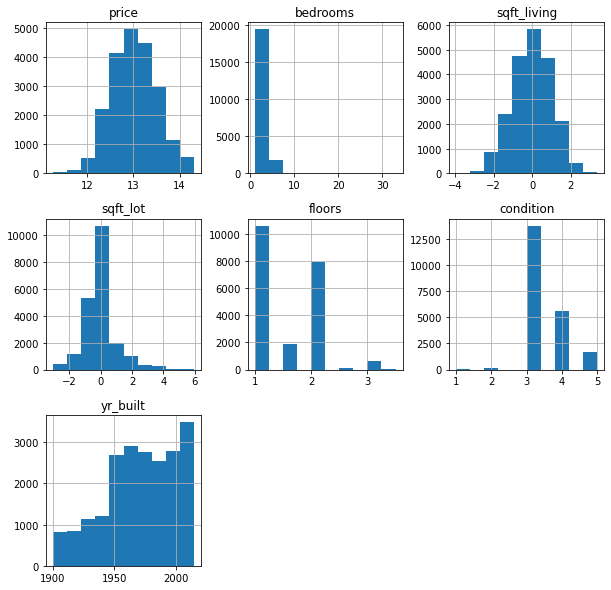

In [16]:
filtered_housing_df.hist(figsize=(10,10))
plt.show()

Now that we have no outliers and our continuous variables have a more normal distribution, we can start building a regression model from our data! 

## Creating our first model

With our filtered and transformed variables, let's review our `housing_df` one more time before deciding which variables to include in our first model.

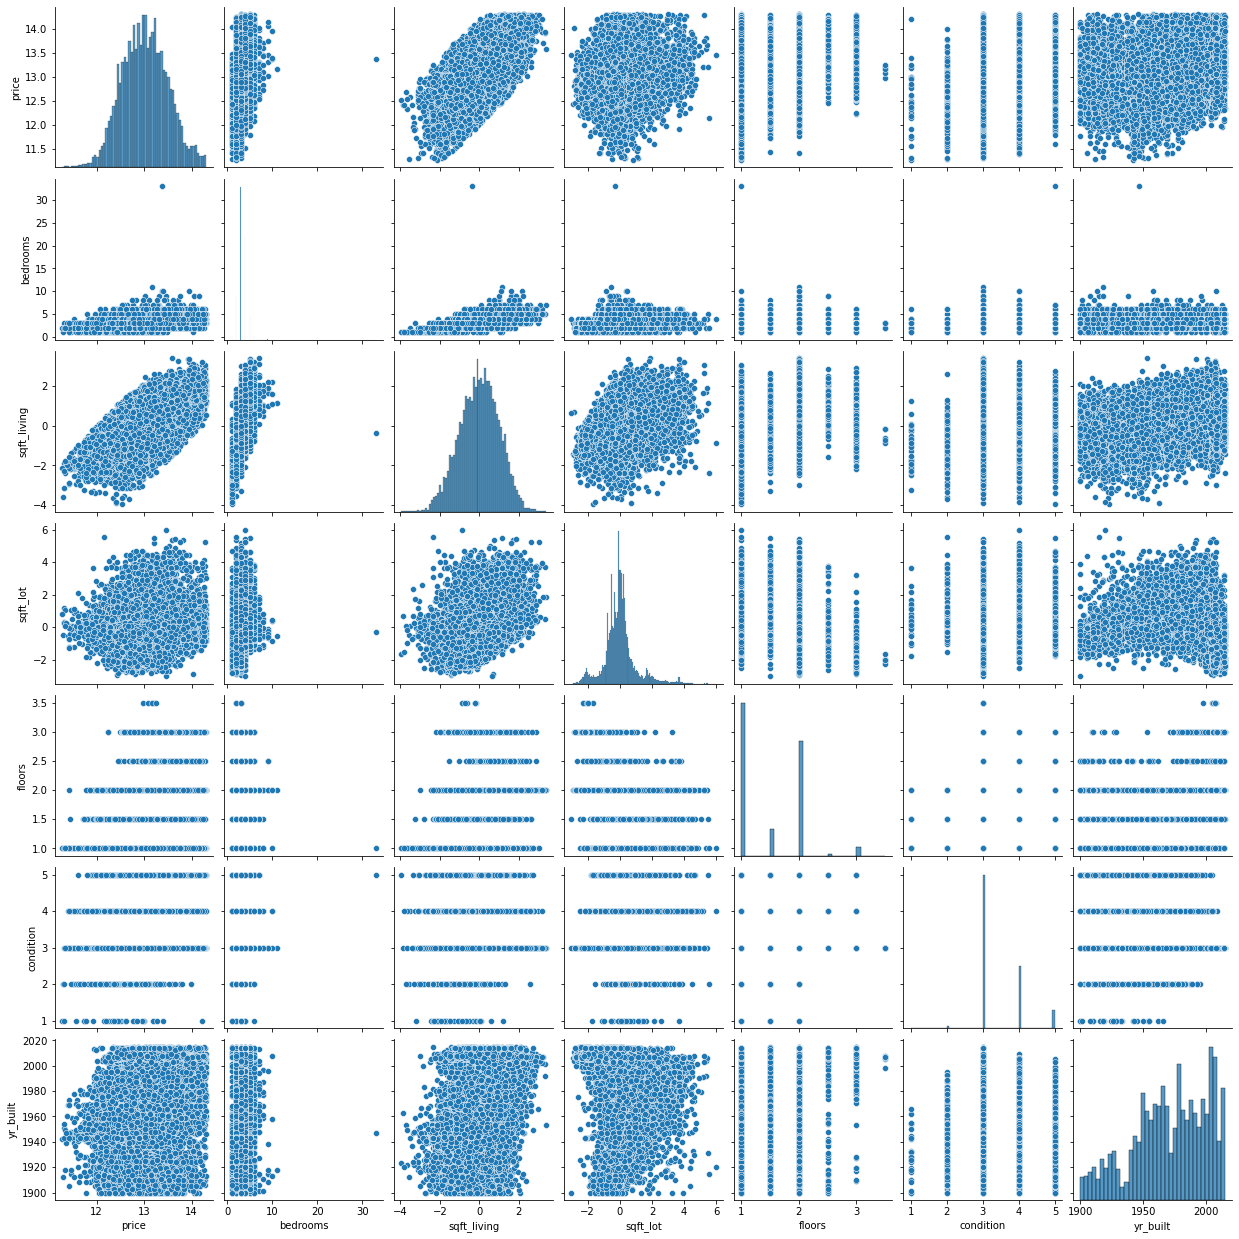

In [17]:
sns.pairplot(filtered_housing_df)

Since `sqft_lot` seems to have the highest positive correlation with `price`, our first model will only contain those variables.

In [18]:
def ols_analysis(df, formula):
    """
    Takes in a dataframe and a regression formula and creates a regression model
    of the data using OLS regression.
    """
    results = ols(formula=formula, data=df).fit()
    return results

def print_params(model):
    """
    Takes in a regression model and prints the R-squared and parameters for
    easier inspection and analysis.
    """
    rsquared = model.rsquared
    params = model.params

    print(f'R-squared: {rsquared}')
    print('----------')
    print('Beta values:')
    print(params)

In [19]:
fsm_df = filtered_housing_df[['price', 'sqft_living']]
formula = 'price ~ sqft_living'
fsm_results = ols_analysis(fsm_df, formula)
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                 1.486e+04
Date:                Mon, 03 May 2021   Prob (F-statistic):               0.00
Time:                        22:58:53   Log-Likelihood:                -9062.2
No. Observations:               21191   AIC:                         1.813e+04
Df Residuals:                   21189   BIC:                         1.814e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.0185      0.003   5106.580      0.000      13.014      13.024
sqft_living     0.3108      0.003    121.902      0.000       0.306       0.316
==============================================================================
Omnibus:                      244.729   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.233
Skew:                          -0.008   Prob(JB):                     1.45e-33
Kurtosis:                       2.586   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
print_params(fsm_results)

R-squared: 0.41221954595264965
----------
Beta values:
Intercept      13.018507
sqft_living     0.310780
dtype: float64


According to this model, for each additional square foot of the house, price increases by 0.31 and for a house with zero square footage, the base price would be about 13.02.
 
Our regression statistic, R-squared, means that this model only explains about 41.2% of the variance in housing prices. Although this is a somewhat low percentage, our model is statistically significant at an alpha level of 0.05, and we can improve the model later on by adding more features.

### Checking assumptions of linear regression

Before continuing, we should check the assumptions of linear regression to ensure the quality of our regression model.

In [21]:
def linearity_test(model):
    """
    Takes a linear regression model and calculates the rainbow statistic and p-value
    to check if the model meets the assumption of linearity.
    """
    rainbow_statistic, rainbow_p_value = linear_rainbow(model)
    print("Rainbow statistic:", rainbow_statistic)
    print("Rainbow p-value:", rainbow_p_value)
    
def normality_test(resids):
    """
    Takes the residuals of a linear regression model and creates a Q-Q
    plot to exhibit whether the model meets the assumption of normality.
    """
    fig = sm.graphics.qqplot(resids, dist=stats.norm, line='45', fit=True)
    fig.show()
    
def homoscedasticity(df, model, resids):
    """
    Takes in a linear regression model and its residuals and creates a scatter plot
    to help determine whether the model meets the assumption of homoscadasticity.
    """
    y = df.iloc[:, 0]
    y_hat = model.predict()
    fig, ax = plt.subplots()
    ax.set(xlabel="Predicted {}".format(y.name),
           ylabel="Residuals (Actual - Predicted {})".format(y.name))
    return ax.scatter(y_hat, resids, alpha=0.2);

def breusch_pagan(df, resids):
    """
    Takes in a dataframe for a linear regression model and its residuals to measure
    for heteroscedasticity.
    """
    predictors_df = df.drop(df.columns[0], axis=1)
    lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(resids, predictors_df)
    print("Lagrange Multiplier p-value:", lm_p_value)
    print("F-statistic p-value:", f_p_value)

### 1. Linearity

The linearity assumption requires that there is a linear relationship between the target variable and the predictors. To check the linearity of our model, we use the [Rainbow test](https://www.tandfonline.com/doi/abs/10.1080/03610928208828423) from the diagnostic submodule of StatsModels.

In [22]:
linearity_test(fsm_results)

Rainbow statistic: 0.972576961211936
Rainbow p-value: 0.9237818313178061


The null is that the model is linearly predicted by the features and the alternative is that it is not. Assuming an alpha of 0.05, since we have a p-value of 0.924 that is greater than our alpha, we cannot reject the null. Therefore, we can assume that the model meets the assumption of linearity.

### 2. Normality

This test checks to see if the model's residuals follow a normal distribution using a Q-Q plot.

<ipython-input-21-96b8f97ffe11>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


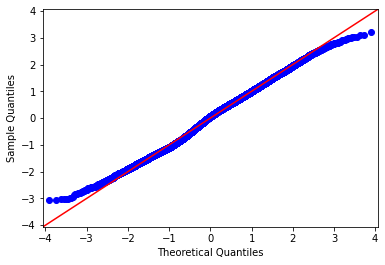

In [23]:
fsm_resids = fsm_results.resid
normality_test(fsm_resids)

When measuring normality, the Q-Q plot is used to assess whether our regression sample comes from a normal distribution. The red line assumes a normal distribution, and our residuals follow the line closely with slight deviations at the min and max values.

We can also use the Jarque-Bera statistic from our regression summary (denoted as Jarque-Bera (JB) and Prob(JB)) to test for normality. The null is that the residuals are normally distributed and the alternative is that they are not. The JB p-value (1.45e-33) is very low, thus we would reject the null, which suggests that this model does not meet the assumption of normality.

### 3. Homoscedasticity

When our data exhibits heteroscedasticity, it means that scatter of the dependent variable widens or narrows as the independent variable increases. The opposite of this is homoscedasticity, in which the distribution of the dependent variable remains constant across all values of the independent variables; a homoscedastic model meets the assumptions of linear regression.

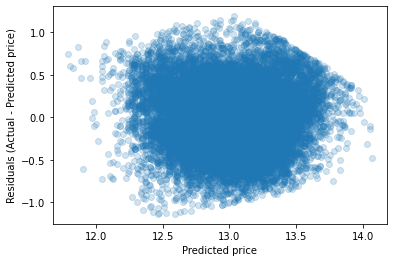

In [24]:
homoscedasticity(fsm_df, fsm_results, fsm_resids)

The scatter plot shows a slight conal pattern to the right and some values don't seem to have an equal distribution across all the values of our target variable. We can also measure for heteroscedasticity statistically using the Breusch-Pagan test found in the diagnostic submodule of StatsModels.

In [25]:
breusch_pagan(fsm_df, fsm_resids)

Lagrange Multiplier p-value: nan
F-statistic p-value: 3.64098522739639e-14


The null is that the model is homoscedastic, while the alternative is that it's heteroscedastic. The low F-statistic p-value that was returned indicates that we would reject the null, therefore this model is heteroscedastic and violates the assumption of homoscedasticity.

### 4. Independence

The independence assumption states that our independent variables should not be too collinear to each other. Since we only have one independent variable in our first model, we don't have to check for this at the moment since this model meets this assumption by default.

## Adding another numerical feature to the model


To try and create a model that can explain more of the variance in housing prices, we can add our other continuous variable, `sqft_lot`, to examine how much the lot size can affect housing prices.

In [26]:
model_2_df = filtered_housing_df[['price', 'sqft_living', 'sqft_lot']]
formula_2 = "price ~ sqft_living + sqft_lot"
model_2_results = ols_analysis(model_2_df, formula_2)
model_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     7735.
Date:                Mon, 03 May 2021   Prob (F-statistic):               0.00
Time:                        22:58:53   Log-Likelihood:                -8884.5
No. Observations:               21191   AIC:                         1.777e+04
Df Residuals:                   21188   BIC:                         1.780e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.0185      0.003   5149.466      0.000      13.014      13.023
sqft_living     0.3264      0.003    122.727      0.000       0.321       0.332
sqft_lot       -0.0504      0.003    -18.931      0.000      -0.056      -0.045
==============================================================================
Omnibus:                      183.466   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.701
Skew:                          -0.014   Prob(JB):                     6.17e-27
Kurtosis:                       2.631   Cond. No.                         1.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
print_params(model_2_results)

R-squared: 0.42199651361883117
----------
Beta values:
Intercept      13.018507
sqft_living     0.326418
sqft_lot       -0.050352
dtype: float64


By adding `sqft_lot` as a predictor, our R-squared only slightly improved from 0.412 to 0.422, suggesting that the square footage of the lot a house is built on is a significant contributor to house price, but not by much more than the square footage of the house itself. Another interesting part of this analysis is that according to this regression, price increases for each additional 0.326 square foot of the house, but decreases for each 0.05 square foot of the lot. 

### Checking assumptions of linear regression

### 1. Linearity

In [28]:
linearity_test(model_2_results)

Rainbow statistic: 0.9690598303531057
Rainbow p-value: 0.9471014604783471


Like our first model, our p-value for this model is also high, so this model also meets the linearity assumption.

### 2. Normality

<ipython-input-21-96b8f97ffe11>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


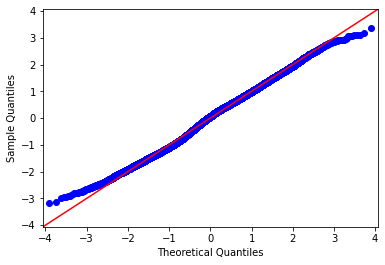

In [29]:
model_2_resids = model_2_results.resid
normality_test(model_2_resids)

The Q-Q plot for this model shows a similar pattern to our first model and mostly sticks to the line that indicates normality with some exceptions at the min and max values of the residual line. However, also in similar fashion to the first model, this model's JB p-value (6.17e-27) is also low, so this model also violates the assumptions of normality.

### 3. Homoscedasticity

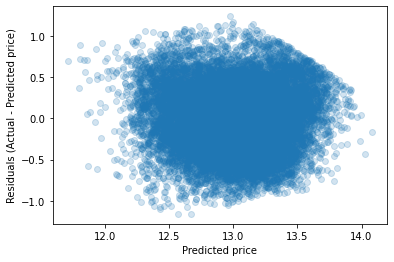

In [30]:
homoscedasticity(model_2_df, model_2_results, model_2_resids)

In [31]:
breusch_pagan(model_2_df, model_2_resids)

Lagrange Multiplier p-value: 2.9706238739930704e-10
F-statistic p-value: 2.362248705306743e-09


Although the scatter plot for the model shows a more equal distribution across all independent variable values, we can still see a slight convergence as the values increase. Our F-statistic p-value is low here as well, indicating that our model is heteroscedastic and violates the assumption of homoscedasticity.

### 4. Independence

Now that we have two independent variables, we can check for the assumption of independence. To do this, we can find the variance inflation factor found in the outlier influence submodule in StatsModels to measure the degree of any multicollinearity in our model.

In [32]:
def independence_test(df):
    """
    Takes in a dataframe for a linear regression model and returns a new dataframe
    containing the variance inflation factors for each feature in the model.
    """
    predictors_df = df.drop(df.columns[0], axis=1)
    rows = predictors_df.values
    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(predictors_df.columns))]
    vif_df["feature"] = predictors_df.columns
    return vif_df

independence_test(model_2_df)

,VIF,feature
0,1.106754,sqft_living
1,1.106754,sqft_lot


As a rule of thumb, a VIF greater than 5 is considered too high and indicates that a variable may be too collinear with another variable. Since none of our predictors' VIFs are greater than that, our model meets the independence assumption.

## Adding categorical features to the model

### Condition

We have no variables in this data set that consist of raw categorical data, but we can consider `condition` as a categorical feature, since it represents the quality of a house's condition upon sale on a scale from 1 to 5. Because these are already numerical values, we won't have to create dummy variables to represent the data.

In [33]:
model_3_df = filtered_housing_df[['price', 'sqft_living', 'sqft_lot', 'condition']]
formula_3 = 'price ~ sqft_living + sqft_lot + condition'
model_3_results = ols_analysis(model_3_df, formula_3)
model_3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     5297.
Date:                Mon, 03 May 2021   Prob (F-statistic):               0.00
Time:                        22:58:54   Log-Likelihood:                -8763.4
No. Observations:               21191   AIC:                         1.753e+04
Df Residuals:                   21187   BIC:                         1.757e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.8112      0.014    947.317      0.000      12.785      12.838
sqft_living     0.3299      0.003    124.302      0.000       0.325       0.335
sqft_lot       -0.0544      0.003    -20.481      0.000      -0.060      -0.049
condition       0.0608      0.004     15.602      0.000       0.053       0.068
==============================================================================
Omnibus:                      163.479   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.400
Skew:                          -0.021   Prob(JB):                     1.06e-24
Kurtosis:                       2.649   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
print_params(model_3_results)

R-squared: 0.4285620696116441
----------
Beta values:
Intercept      12.811185
sqft_living     0.329899
sqft_lot       -0.054428
condition       0.060833
dtype: float64


Here, we see an even slighter improvement of our R-squared from 0.422 to 0.429.

### Checking assumptions of linear regression

### 1. Linearity

In [35]:
linearity_test(model_3_results)

Rainbow statistic: 0.9694369011328645
Rainbow p-value: 0.9449027847615037


We satisfy the linearity assumption again with a high p-value here as well.

### 2. Normality

<ipython-input-21-96b8f97ffe11>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


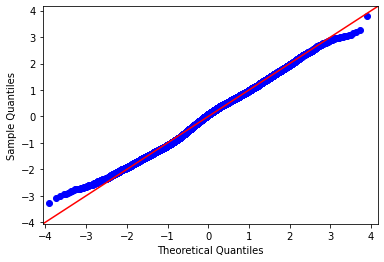

In [36]:
model_3_resids = model_3_results.resid
normality_test(model_3_resids)

Our Q-Q plot doesn't seem to have changed much, and while our JB score is steadily improving, the p-value (1.06e-24) is still low and unfortunately, our model still violates the normality assumption.

### 3. Homoscedasticity

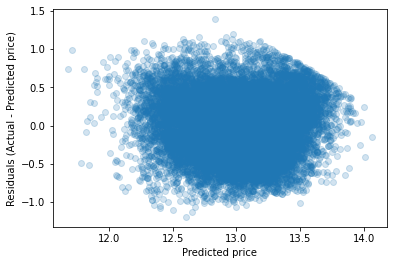

In [37]:
homoscedasticity(model_3_df, model_3_results, model_3_resids)

In [38]:
breusch_pagan(model_3_df, model_3_resids)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


The scatter plot of this model's residuals looks about the same as the previous ones. There is a slight improvement in our F-statistic p-value from the Breusch-Pagan test, but our model is still heteroscedastic here.

### 4. Independence

In [39]:
independence_test(model_3_df)

,VIF,feature
0,1.107026,sqft_living
1,1.107127,sqft_lot
2,1.000447,condition


The VIFs for our predictors are still low very well below 5, so this model meets the assumption of independence.

### Floors

I also wanted to see if the amount of floors in houses affected their value in any way. I treat floors as a categorical variable because there is only a reasonable amount of floors a house may have and it isn't necessarily a variable that is easily influenced by any other factors.

In [40]:
filtered_housing_df['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [41]:
model_4_df = filtered_housing_df[['price', 'sqft_living', 'sqft_lot', 'condition', 'floors']]
formula_4 = 'price ~ sqft_living + sqft_lot + condition + floors'
model_4_results = ols_analysis(model_4_df, formula_4)
model_4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     4035.
Date:                Mon, 03 May 2021   Prob (F-statistic):               0.00
Time:                        22:58:54   Log-Likelihood:                -8692.4
No. Observations:               21191   AIC:                         1.739e+04
Df Residuals:                   21186   BIC:                         1.743e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.6698      0.018    706.143      0.000      12.635      12.705
sqft_living     0.3131      0.003    104.444      0.000       0.307       0.319
sqft_lot       -0.0406      0.003    -14.057      0.000      -0.046      -0.035
condition       0.0729      0.004     18.156      0.000       0.065       0.081
floors          0.0674      0.006     11.938      0.000       0.056       0.078
==============================================================================
Omnibus:                      153.185   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.053
Skew:                          -0.000   Prob(JB):                     2.54e-23
Kurtosis:                       2.657   Cond. No.                         29.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
print_params(model_4_results)

R-squared: 0.43238031771012386
----------
Beta values:
Intercept      12.669809
sqft_living     0.313068
sqft_lot       -0.040625
condition       0.072907
floors          0.067410
dtype: float64


We can see yet another slight improvement in our R-squared, increasing from 0.429 to 0.432.

### Checking assumptions of linear regression

### 1. Linearity

In [43]:
linearity_test(model_4_results)

Rainbow statistic: 0.9642680396456231
Rainbow p-value: 0.969422505204123


Like our previous models, this model has no issue meeting the linearity assumption.

### 2. Normality

<ipython-input-21-96b8f97ffe11>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


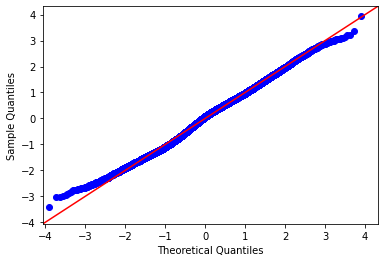

In [44]:
model_4_resids = model_4_results.resid
normality_test(model_4_resids)

The Q-Q plot for this model looks similar to those of our previous models, and the JB p-value (2.54e-23) has increased again, but it still isn't enough for this model to meet the normality assumption.

### 3. Homoscedasticity

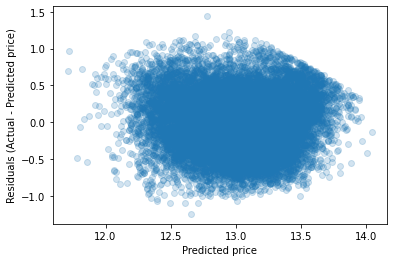

In [48]:
homoscedasticity(model_4_df, model_4_results, model_4_resids)

In [46]:
breusch_pagan(model_4_df, model_4_resids)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


From our previous model, there is no noticeable difference in our scatter plot nor in our p-value; our model still violates the homoscedasticity assumption.

### 4. Independence

In [47]:
independence_test(model_4_df)

,VIF,feature
0,1.337693,sqft_living
1,1.278592,sqft_lot
2,6.943035,condition
3,7.167965,floors


Although `sqft_living` and `sqft_lot` are still okay, we do have high VIFs for `condition` and `floors` that suggest high multicollinearity. While we do have a higher regression statistic from including `floors`, we also created a model that violates the independence assumption.

## Conclusion

When we started out with our model containing `sqft_living` as our only predictor, we created a statistically significant model that explained just a minority of the variance in housing prices in King County. Our R-squared was 0.412 and while our model met the assumptions of linearity and independence, it failed to meet the other assumptions of normality and homoscedasticity.

As we added more features, our R-squared steadily improved, but our models still failed to meet the assumptions of normality and homoscedasticity. The best model that we made had `sqft_living`, `sqft_lot`, and `condition` as predictors. It had an R-squared of 0.429 and like our first model, met the assumptions of linearity but as mentioned, didn't meet those for normality or homoscedasticity. It also passed the independence assumption; the variance influence factors did not indicate any signs of multicollinearity. While the last model with `floors` included gave us a higher R-squared of 0.432, it also exhibited higher multicollinearity and may be more inaccurate as a result.

While we didn't end up creating the best models with our regression models, because they are still statistically significant we can still gain some sort of insight and direction from them. From those results, we can give these answers to our questions: 

1. *What kinds of factors contribute to a house's base value?*

Although our models didn't meet all the assumptions of linear regression, they were all statistically significant, so we can reasonably assume that all four features measured -- `sqft_living`, `sqft_lot`, `condition`, and `price` -- are all factors that can have an impact on a house's base value. Specifically, according to our best model:

- A house's base value with no features would be about 12.670.
- For each unit increase in the square footage of the house, price increases by 0.313.
- For each unit increase in the square footage of the lot, price decreases by 0.041.
- For each unit increase in a house's condition, price increases by 0.061.

Even though these parameters are statistically significant, it's also important to keep in mind that this model only explains about 42.9% of the variance in housing prices, which isn't a terrible proportion, but it hardly represents a good majority. 

2. *When building a house, what factors should we look out for before beginning the construction of property?*

Some factors that we can pay attention to based on this model is the proportion between square footage of the house and the lot we build the lot on. In our model, price tended to decrease with square footage of the lot. While the lot size didn't show collinearity with the house size, one reason why lot size has a negative impact on the model may be because as more house is built, it means less free lot size.

3. *How does the condition of a house at the point of sale influence the value of a house?*

Significantly, but not by enough to make a notable difference. As we saw in our model, each increase in a house's condition score would only increase price by about 0.061. Condition may be more of a factor that influences whether a house is bought rather than a factor that influences its price.

4. *Are there specific features that add significant value to houses (e.g. rooms, floors)?*

Bedrooms and bathrooms didn't really contribute much to our model, so it's hard to speak on their influence on a house's base value. As for the number of floors, it's significant enough to impact the variance in prices, but not by much, only affecting price by about 0.067 in our last model.

### What's next?

To try and create more reliable regression models that can better explain and answer our questions what impacts housing prices, there are some steps we can take going forward:

- Finding different ways to scale and transform data to gain better regression statistics, since transforming all our continuous data wasn't enough to improve the reliability of our results by much.
- Regression analysis on housing prices in other highly populated counties in the U.S. (Los Angeles, New York, etc.) and less populated counties in Washington to potentially discover other factors behind housing prices such as business and tourism.
- Using data about how housing prices change over time in response to economic factors (i.e. inflation) in conjunction with our data about house sales may help us be proactive in our decisions as prospective developers.

I'd also like to point out that performing a regression analysis on our data in its raw state (with no feature scaling, transformations, or filtering) led to a model with higher R-squared's, but didn't even come close to meeting any of the assumptions of linear regression. Consequently, they are also more unreliable than the models we produced here, and should be taken with a very light grain of salt. If you would like to review the notebook, you can find it [here](./Property_Development_Analysis_unfiltered.ipynb) in the same repository as this project.